# Importing required libraries

In [171]:
%matplotlib inline
import sys
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle 
import numpy as np
import cv2
from random import randint # to generate random positive integers between a range of numbers
import pandas as pd
from skimage import filters as ski_fil
from skimage import transform as ski_tr
from skimage import color
from skimage import exposure as e
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score
import matplotlib.gridspec as gridspec


# Functions 

In [172]:
# Serialization using pickle

def pickle_load(filename = 'newfile.p'):
    
    path = './traffic-signs-data/'+filename

    with open(path, 'rb') as f:
        data = pickle.load(f)
        f.close()
        
    return data
# Deserialization using pickle 

def pickle_dump(data, filename = 'newfile.p'):
    
    path = './traffic-signs-data/'+filename
    
    with open(path, 'wb') as f:
        pickle.dump(data, f)
        f.close()
        
# Viewing 100 images from the data set with labels. 
def view_100_images(image_list, label_list, index_start, index_end, random=True, cmap_name=None):
    
    fig =plt.figure(figsize=(15,15))
    
    if random==True:
        for a in range(1,101):
            img = randint(index_start,index_end-1)    
            fig.add_subplot(10,10,a)
            plt.title(label_list[img])
            plt.imshow(image_list[img], cmap=cmap_name)
    else:
        for a in range(1,101):
            for img in range(index_start,index_start+100):
                fig.add_subplot(10,10,a)
                plt.title(label_list[img])
                plt.imshow(image_list[img], cmap=cmap_name)
        
                    
# Data Augmentation               
def image_generator(image_features, image_labels, start=None, end=None, hop=10):
        if end is None:
            end=len(image_features)
        if start is None:
            start=0
    
        aug_labels =np.zeros(0, dtype=np.uint8)
        aug_images_temp = np.zeros((32,32,3),dtype=np.uint8)
        aug_images = np.zeros((0,32,32,3),dtype=np.uint8)
        
        for i in range(start, end, hop):
            #print(i)
            
            # Horizontal_flip
            #a1 = np.fliplr(image_features[i]) 
            #aug_labels = np.append(aug_labels, image_labels[i])
            
            # Vertical flip
            #a2 = np.flipud(image_features[i])
            #aug_labels = np.append(aug_labels, image_labels[i])
            
            # Image blur
            a3 = ski_fil.gaussian(image_features[i], sigma=1, multichannel=True) 
            aug_labels = np.append(aug_labels, image_labels[i])
            
            # Orignal image rotation 0.5
            tform = ski_tr.AffineTransform(scale=(1, 1), rotation=0.5, translation=(0, 0))
            a4 = ski_tr.warp(image_features[i], tform.inverse)
            aug_labels = np.append(aug_labels, image_labels[i])
            
            # Orignal image rotation -0.5
            tform = ski_tr.AffineTransform(scale=(1, 1), rotation=-0.5, translation=(0, 0))
            a5 = ski_tr.warp(image_features[i], tform.inverse)
            aug_labels = np.append(aug_labels, image_labels[i])
            
            ## Downscaling image 0.5x0.5 and rotation -0.2
            #tform = ski_tr.AffineTransform(scale=(0.5, 0.5), rotation=-0.2, translation=(0, 0))
            #a6 = ski_tr.warp(image_features[i], tform.inverse)
            #aug_labels = np.append(aug_labels, image_labels[i])
            
            # Downscaling image 0.5x0.5 and translation 5,-3
            #tform = ski_tr.AffineTransform(scale=(0.5, 0.5), rotation=0, translation=(5, -3))
            #a7 = ski_tr.warp(image_features[i], tform.inverse)
            #aug_labels = np.append(aug_labels, image_labels[i])
            
            # Image streching 
            #tform = ski_tr.AffineTransform(scale=(1, 1.8), rotation=0, translation=(0, 0))
            #a8 = ski_tr.warp(image_features[i], tform.inverse)
            #aug_labels = np.append(aug_labels, image_labels[i])
            
            aug_images_temp = np.vstack(([a3],[a4],[a5]))
            aug_images = np.append(aug_images, aug_images_temp,axis=0)
            
        return aug_images, aug_labels

# Making zero mean and SD    
def normalize(x):
    for i in range(0, len(x)):
        pmean=np.mean(x[i])
        #print(pmean)
        pstd=np.std(x[i])
        #print(pstd)
        x[i] = (x[i] - pmean)/pstd
    return x

# Min Max scaling
def min_max_scaling(x):

    for i in range(0,len(x)):
        pmin = np.min(x[i])
        pmax = np.max(x[i])
        x[i] = (x[i]-pmin)/(pmax-pmin)
    return x

#Adaptive histogram Equalization to increase the contrast
def adapt_equalize(img_list):
    
    for i in range(0, len(img_list)):
        img_list[i] = e.equalize_adapthist(img_list[i],clip_limit=0.05)
    return img_list

#Evaluating the performance of the model 
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#Printing the feature maps or activations
def print_activations(X_data):
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    c1,c2= sess.run([conv1, conv2], feed_dict={x:X_data[1999:2000],dropout_prob:1})
    
    print(c1.shape)
    #plt.imshow(c1[0,:,:,1], cmap='gray')
    print(c2.shape)
    #print(fc1.shape)

    fig1 = plt.figure(figsize= (6,1))
    plt.title('conv1 activations')
    for img in range(1,7):
        fig1.add_subplot(1,6,img)
        plt.imshow(c1[0,:,:,img], cmap='gray')
    fig2 = plt.figure(figsize= (6,1))
    plt.title('conv2 activations')
    for img in range(1,7):
        fig2.add_subplot(1,6,img)
        plt.imshow(c2[0,:,:,img], cmap='gray')
        
# Getting the predictions and labels data from the model to calculate precision and recall
def get_pred_label(X_data, y_data):
    final_p=np.zeros(0)
    final_l=np.zeros(0)
    num_examples = len(X_data)
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            predict, lab =sess.run([pred, label], feed_dict={x: batch_x, y: batch_y, dropout_prob:1})
            final_p = np.append(final_p,predict)
            final_l=np.append(final_l,lab)
    return final_p, final_l 

# Preprocessing Pipeline
def preprocessing(img_features): # accepts a list of 32x32 images
    # Declare some empty numpy arrays
    x_features = np.zeros((len(img_features),32,32))
    
    #Convert the images from RGB to Grayscale
    x_features = color.rgb2gray(img_features)
    
    #Normalize the data to have 0 mean and SD
    x_features = normalize(x_features)
    
    #Apply min max scaling
    x_features = min_max_scaling(x_features)
    
    #Apply adaptive equalization to increase the contrast intuitively 
    x_features = adapt_equalize(x_features)
    
    return x_features

#Getting the top5 softmax
def get_top5_softmax(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        top5_softmax = sess.run([logits, tf.nn.top_k(logits, 5)], feed_dict={x: batch_x, y: batch_y, dropout_prob:1})
    return top5_softmax

#Plotting the top5 softmax
def plot_top5_softmax(X_data, top5_softmax):
    for i in range(len(X_data)):
        plt.figure(figsize = (5,3))
        gs = gridspec.GridSpec(1, 2)
        plt.subplot(gs[0])
        plt.axis('off')
        plt.imshow(x_web[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(gs[1])
        plt.barh(5-np.arange(5),top5_softmax[1][0][i], align='center')
        for Xlabel in range(5):
            lab = top5_softmax[1][1][i][Xlabel]
            plt.text(top5_softmax[1][0][i][Xlabel],5-Xlabel, df.loc[lab, 'SignName'])
        plt.axis('off')
        plt.show()

# Data Loading

In [28]:
train_images = pickle_load('train.p')
valid_images = pickle_load('valid.p')
test_images = pickle_load('test.p')
    
train_features, train_label = train_images['features'], train_images['labels']
valid_features, valid_label = valid_images['features'], valid_images['labels']
test_features, test_label = test_images['features'], test_images['labels']

# Data Visualization and Data Augmentation

### Data Visualization before Data Augmentation

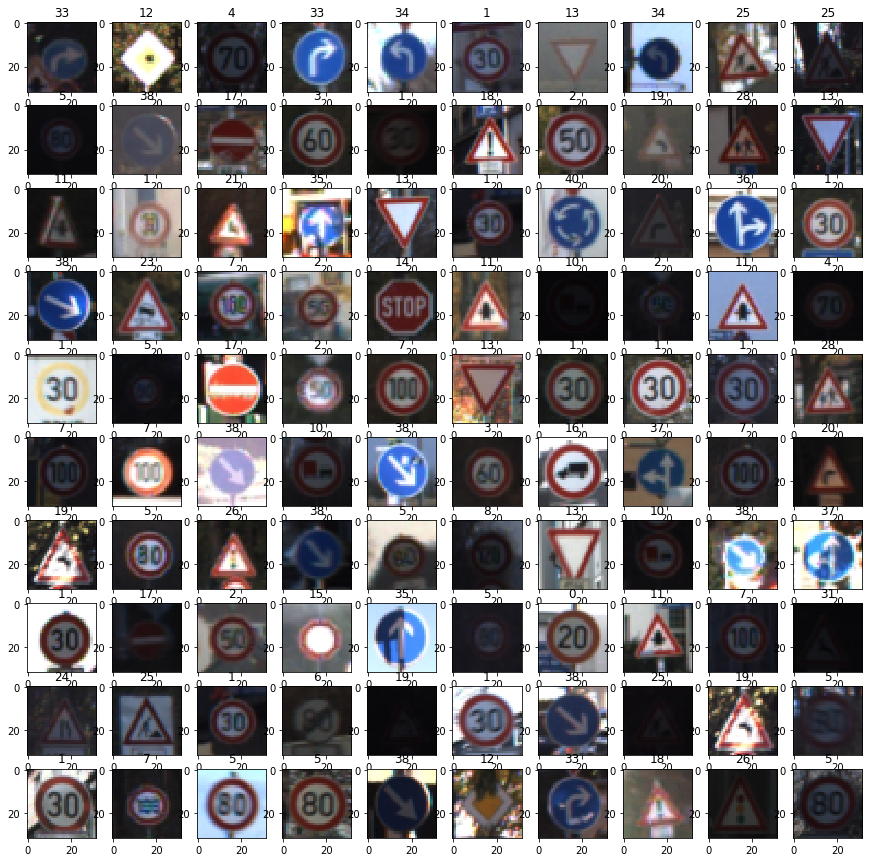

In [4]:
#Viewing 100 random images from the orginal data to get a feel of data

view_100_images(train_features, train_label, index_start =0, index_end=len(train_features), random=True)

In [142]:

df = pd.read_csv('signnames.csv')
df2 = pd.DataFrame(train_label)

df2.columns = ['ClassId']
df2 = df2.merge(df, on='ClassId', how='left') # merging a column into another df 
df3=df2.groupby(['ClassId']).count() #group by and getting unique count of each class

print(df3)
df3.describe()

         SignName
ClassId          
0             180
1            1980
2            2010
3            1260
4            1770
5            1650
6             360
7            1290
8            1260
9            1320
10           1800
11           1170
12           1890
13           1920
14            690
15            540
16            360
17            990
18           1080
19            180
20            300
21            270
22            330
23            450
24            240
25           1350
26            540
27            210
28            480
29            240
30            390
31            690
32            210
33            599
34            360
35           1080
36            330
37            180
38           1860
39            270
40            300
41            210
42            210


SignName
count    43.000000
mean    809.279070
std     626.750855
min     180.000000
25%     285.000000
50%     540.000000
75%    1275.000000
max    2010.000000

In [205]:
df7.reset_index(level=0, inplace=True)

In [206]:
df7.columns = ['ClassId', 'Count']

In [210]:
df7 =df7.sort_values(by=['Count'])

In [211]:
df5 =df5.sort_values(by=['ClassId'])

In [215]:
df5.insert(loc=2, column='Label', value=df7['ClassId'])

In [212]:
df7.insert(loc=1, column='SignName', value=df5['SignName'])

In [110]:
df4=df2.groupby(['SignName']).count() #group by and getting unique count of each class
#df4['ClassNames'] = df4.index 
print(df4)
df4.describe()

                                                    ClassId
SignName                                                   
Ahead only                                             1080
Beware of ice/snow                                      390
Bicycles crossing                                       240
Bumpy road                                              330
Children crossing                                       480
Dangerous curve to the left                             180
Dangerous curve to the right                            300
Double curve                                            270
End of all speed and passing limits                     210
End of no passing                                       210
End of no passing by vehicles over 3.5 metric tons      210
End of speed limit (80km/h)                             360
General caution                                        1080
Go straight or left                                     180
Go straight or right                    

ClassId
count    43.000000
mean    809.279070
std     626.750855
min     180.000000
25%     285.000000
50%     540.000000
75%    1275.000000
max    2010.000000

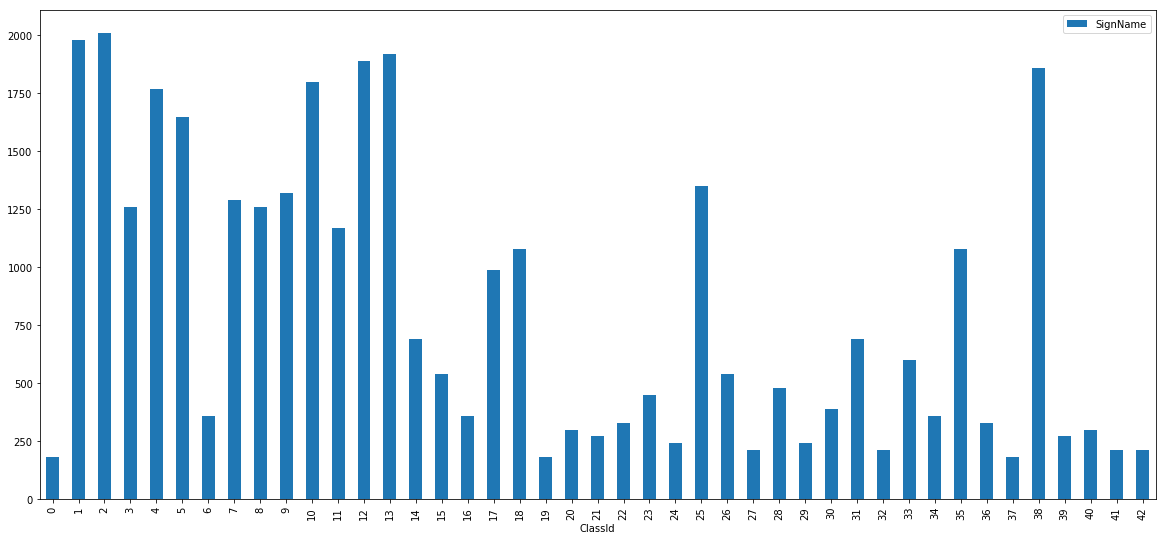

In [6]:
plt.rcParams['figure.figsize'] = (20,9) #increasing the size of the plot figure
df3.plot(kind='bar')


In [8]:
df3['SignName'].nlargest(10) # Top 10 classes

ClassId
2     2010
1     1980
13    1920
12    1890
38    1860
10    1800
4     1770
5     1650
25    1350
9     1320
Name: SignName, dtype: int64

In [9]:
df3['SignName'].nsmallest(10) # last 10 classes



ClassId
0     180
19    180
37    180
27    210
32    210
41    210
42    210
24    240
29    240
21    270
Name: SignName, dtype: int64

/Users/wajid/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


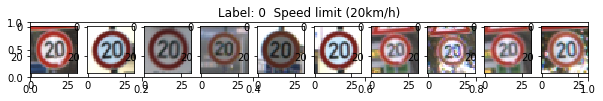

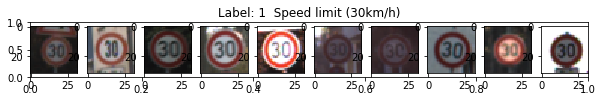

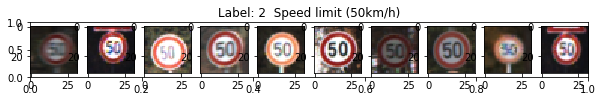

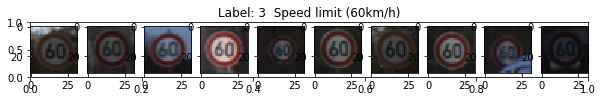

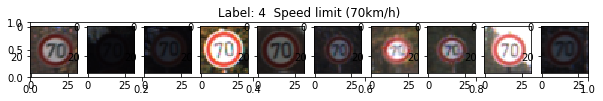

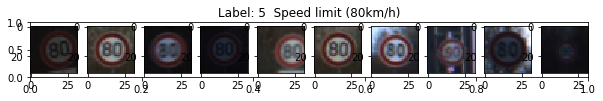

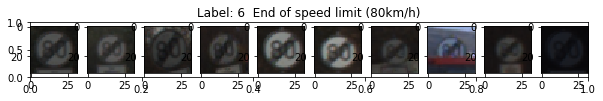

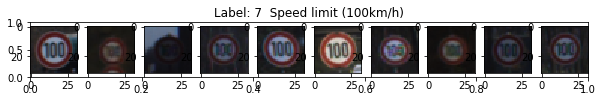

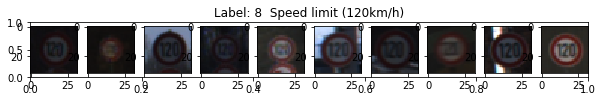

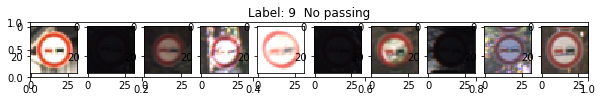

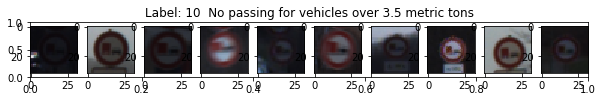

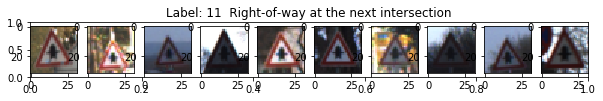

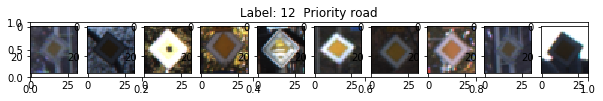

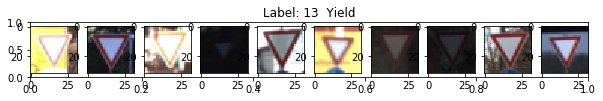

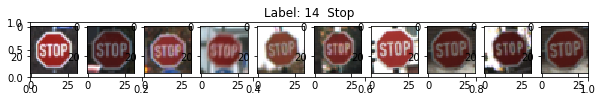

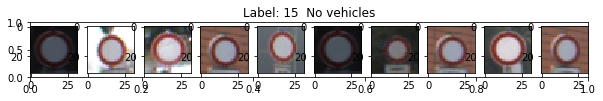

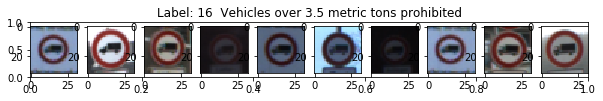

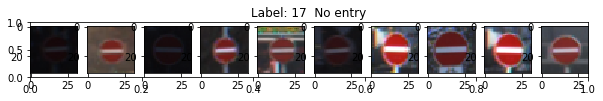

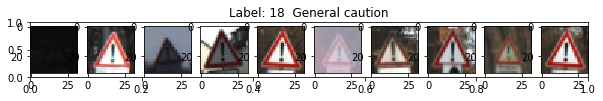

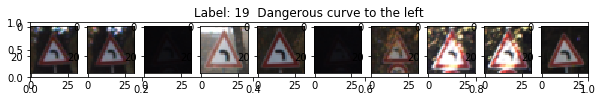

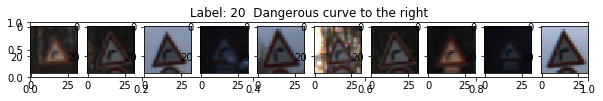

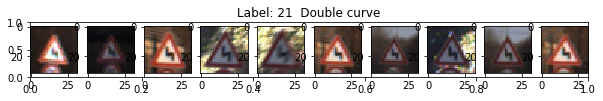

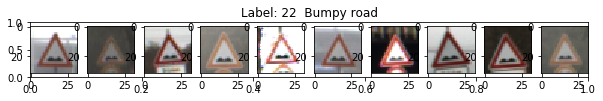

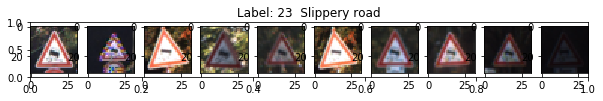

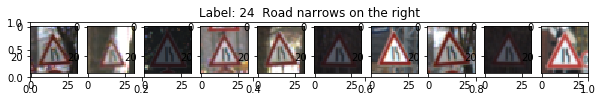

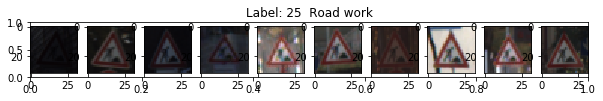

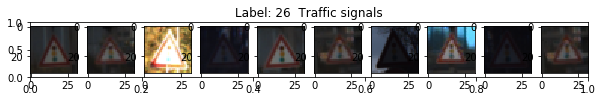

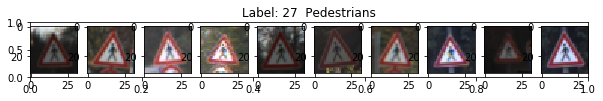

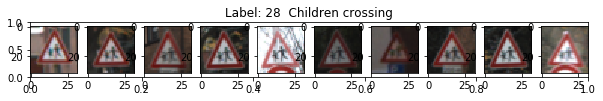

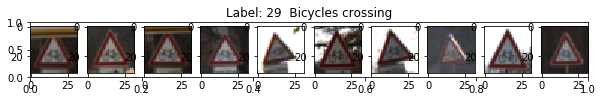

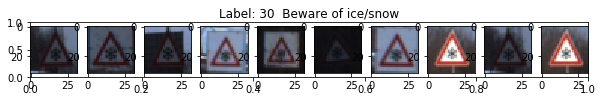

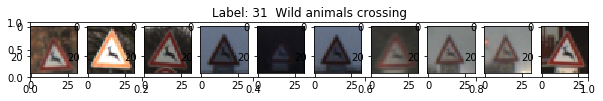

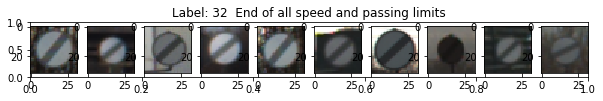

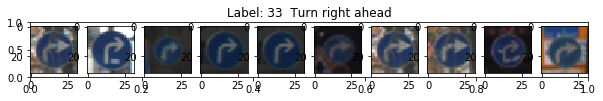

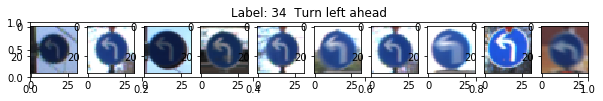

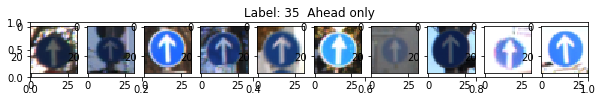

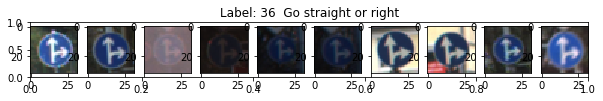

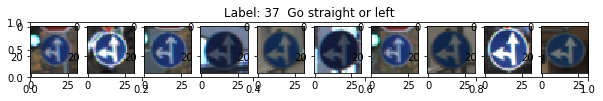

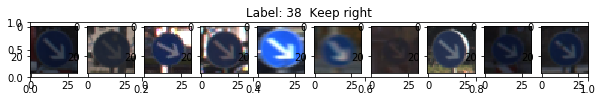

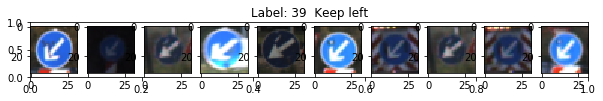

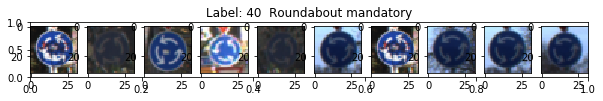

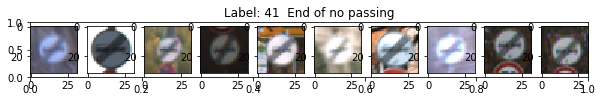

In [11]:
plt.rcParams['figure.figsize'] =(10,6) 

# Viewing 10 random images for each class
for label in range(0,43):
    fig = plt.figure(figsize=(10,1))
    #plt.axes(frameon=False)

    df_filtered = df2.query('ClassId==@label') #filtering the dataframe for specific label and storing it in df_filtered
    plt.title('Label: '+str(label)+'  '+str(df.loc[label,'SignName']))
    for img in range(1,11):
        rand2 = randint(0, len(df_filtered))
        fig.add_subplot(1,10,img)
        plt.imshow(train_features[df_filtered.index[rand2-1]])

### Data Augmentation

In [30]:
#Generating fake images in general for the entire data set. The default is 10 hops meaning the the function will
#create 1 image every 10 images in the data set. there this line generate len(train_features)/10 images = 34799/10
# = 3479x3(3 types of augmentation see image generator function for more details) = 10437 images 

#aug_images, aug_labels  = image_generator(train_features, train_label) 

#During initial phase of training it is noted that the recall and precision has beeen low for the below class.
#Also it is noted that these classes have less images compared to others. Hence additional images generated for these
#classes. The hop is set to 1 which means produce len(class)x3 images. For example: Class 20 has 299( 26249-25950) images
# Hence it will produce 299x3 images = 897 images

aug_images_20, aug_labels_20  = image_generator(train_features, train_label, start=25950, end=26249, hop=1) 
aug_images_0, aug_labels_0    = image_generator(train_features, train_label, start=9960, end=10139, hop=1) 
aug_images_19, aug_labels_19  = image_generator(train_features, train_label, start=6630, end=6809, hop=1) 
aug_images_37, aug_labels_37  = image_generator(train_features, train_label, start=4830, end=5009, hop=1) 
aug_images_27, aug_labels_27  = image_generator(train_features, train_label, start=10350, end=10559, hop =1) 
aug_images_32, aug_labels_32  = image_generator(train_features, train_label, start=10140, end=10349, hop=1) 
aug_images_41, aug_labels_41  = image_generator(train_features, train_label, start=0, end=209, hop=1) 
aug_images_42, aug_labels_42  = image_generator(train_features, train_label, start=9750, end=9959, hop=1) 
aug_images_24, aug_labels_24  = image_generator(train_features, train_label, start=10800, end=11039, hop=1) 
aug_images_29, aug_labels_29  = image_generator(train_features, train_label, start=10560, end=10799, hop=1) 
aug_images_21, aug_labels_21  = image_generator(train_features, train_label, start=25680, end=25949, hop=1) 

# Here all the specific class images are combinned in to single numpy array

aug_images_other = np.vstack((aug_images_20, aug_images_0,aug_images_19, aug_images_37,aug_images_27, aug_images_32,\
                              aug_images_41,aug_images_42,aug_images_24, aug_images_29, aug_images_21))
aug_labels_other = np.hstack((aug_labels_20, aug_labels_0,aug_labels_19, aug_labels_37,aug_labels_27, aug_labels_32,\
                              aug_labels_41,aug_labels_42,aug_labels_24, aug_labels_29, aug_labels_21))


(52496, 32, 32, 3)
(52496,)
20


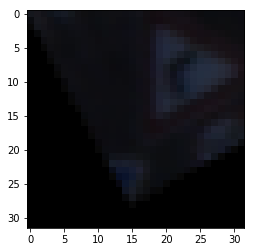

In [31]:
aug_images = pickle_load('aug_images.p')
aug_labels = pickle_load('aug_labels.p')

#Combining the entire augmentated data( specific class data and overall data) with orginal data

train_features_dag = np.append(train_features, aug_images, axis=0)
train_labels_dag = np.append(train_label, aug_labels, axis=0)
train_features_dag = np.append(train_features_dag, aug_images_other, axis=0)
train_labels_dag = np.append(train_labels_dag, aug_labels_other, axis=0)

#Checking the shapes and length of the combined data set. Originally 34799 images were present in the data set.
#After data augmentation we added additional 17697 images to the data set. Totalling to 52496 data
print(train_features_dag.shape)
print(train_labels_dag.shape)
plt.imshow(train_features_dag[45709])
print(train_labels_dag[45709])

### Data Visualization after Data Augmentation

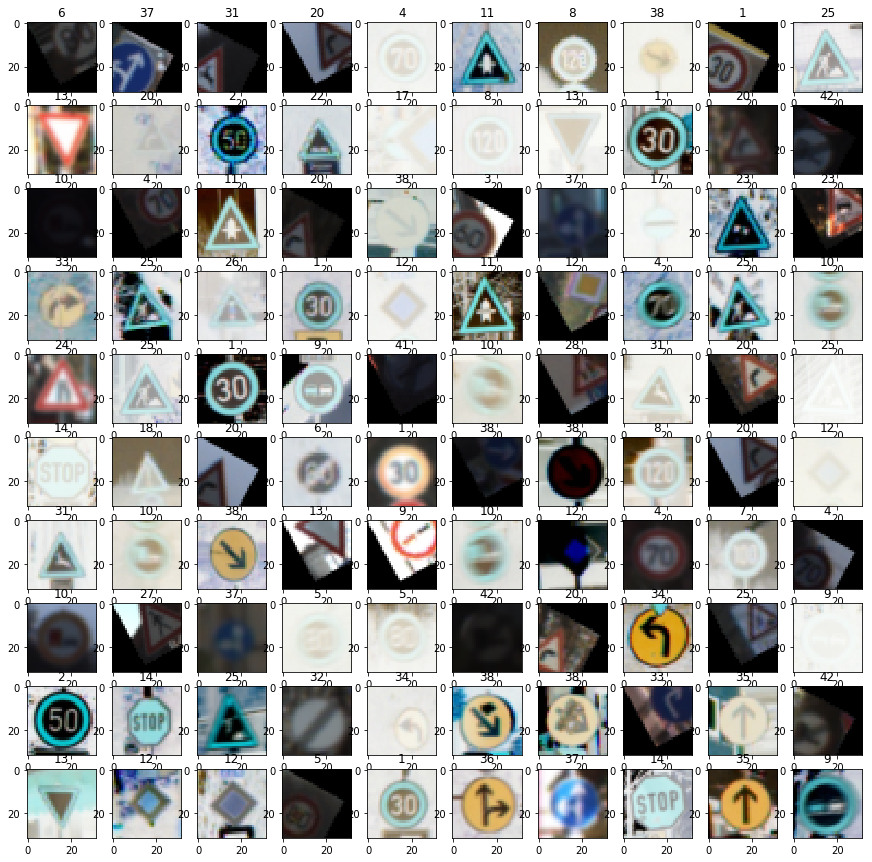

In [74]:
view_100_images(train_features_dag, train_labels_dag, index_start =0, index_end=len(train_features_dag), random=True)

In [75]:
#_dag means with data augmentated images.

df_dag = pd.read_csv('signnames.csv')
df2_dag = pd.DataFrame(train_labels_dag)
#label=41
#df.loc[label,'SignName']

df2_dag.columns = ['ClassId']
df2_dag = df2_dag.merge(df_dag, on='ClassId', how='left') # merging a column into another df 
df3_dag=df2_dag.groupby(['ClassId']).count() #group by and getting unique count of each class

print(df3_dag)
df3_dag.describe()

         SignName
ClassId          
0             771
1            2574
2            2613
3            1638
4            2301
5            2145
6             468
7            1677
8            1638
9            1716
10           2340
11           1521
12           2457
13           2496
14            897
15            702
16            468
17           1287
18           1404
19            771
20           1287
21           1158
22            429
23            585
24           1029
25           1755
26            702
27            900
28            624
29           1029
30            507
31            897
32            900
33            779
34            468
35           1404
36            429
37            771
38           2418
39            351
40            390
41            900
42            900


SignName
count    43.000000
mean   1220.837209
std     700.228532
min     351.000000
25%     702.000000
50%     900.000000
75%    1657.500000
max    2613.000000

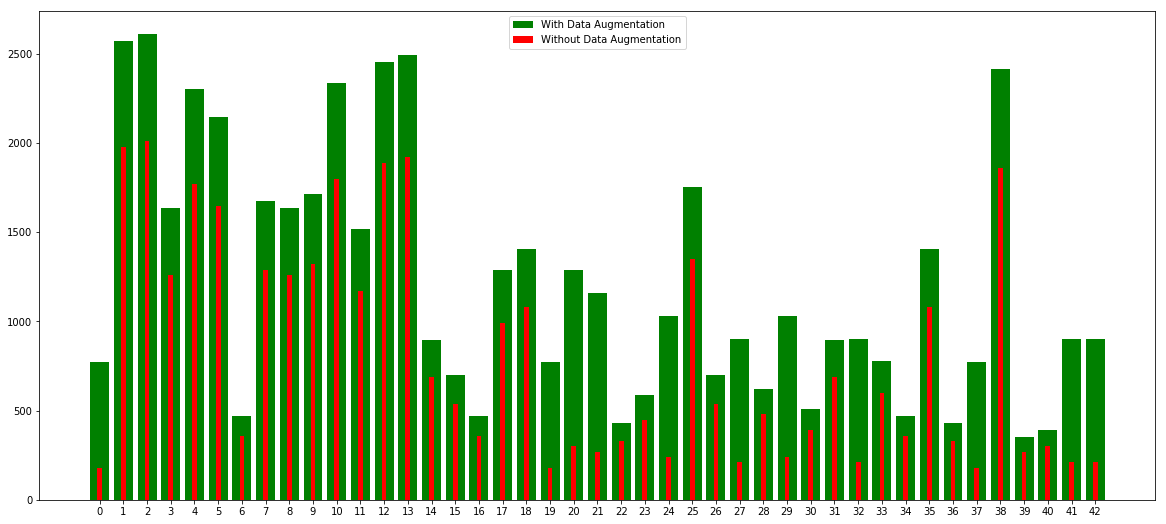

In [76]:
plt.rcParams['figure.figsize'] = (20,9) #increasing the size of the plot figure
#fig = plt.figure(figsize=(10,10))
#fig.add_subplot(2,1,1)
#df3_dag.plot(kind='bar')
#fig.add_subplot(2,1,2)
#df3.plot(kind='bar')
#x=
ax = plt.subplot(111)
ax.bar(df3_dag.index, df3_dag['SignName'],color='g',align='center')
ax.bar(df3.index, df3['SignName'],width=0.2,color='r',align='center')
ax.legend(('With Data Augmentation','Without Data Augmentation'), loc=9)
ax= plt.xticks(df3.index)

In [77]:
df4=df2.groupby(['SignName']).count() #group by and getting unique count of each class
print(df4)
df4.describe()

                                                    ClassId
SignName                                                   
Ahead only                                             1080
Beware of ice/snow                                      390
Bicycles crossing                                       240
Bumpy road                                              330
Children crossing                                       480
Dangerous curve to the left                             180
Dangerous curve to the right                            300
Double curve                                            270
End of all speed and passing limits                     210
End of no passing                                       210
End of no passing by vehicles over 3.5 metric tons      210
End of speed limit (80km/h)                             360
General caution                                        1080
Go straight or left                                     180
Go straight or right                    

ClassId
count    43.000000
mean    809.279070
std     626.750855
min     180.000000
25%     285.000000
50%     540.000000
75%    1275.000000
max    2010.000000

In [81]:
df3['SignName'].nlargest(20) # Top 10 classes

ClassId
2     2010
1     1980
13    1920
12    1890
38    1860
10    1800
4     1770
5     1650
25    1350
9     1320
7     1290
3     1260
8     1260
11    1170
18    1080
35    1080
17     990
14     690
31     690
33     599
Name: SignName, dtype: int64

In [80]:
df3['SignName'].nsmallest(20) # last 10 classes



ClassId
0     180
19    180
37    180
27    210
32    210
41    210
42    210
24    240
29    240
21    270
39    270
20    300
40    300
22    330
36    330
6     360
16    360
34    360
30    390
23    450
Name: SignName, dtype: int64

/Users/wajid/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


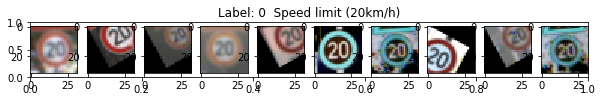

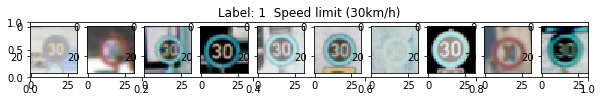

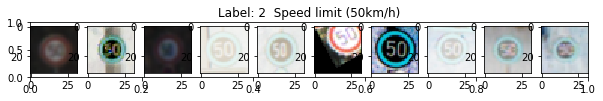

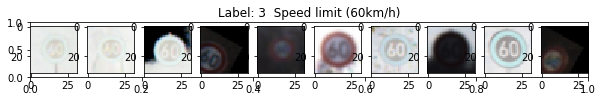

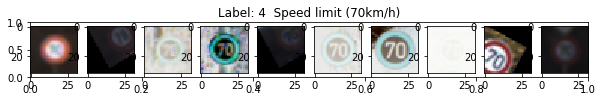

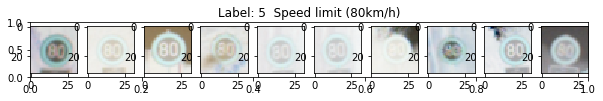

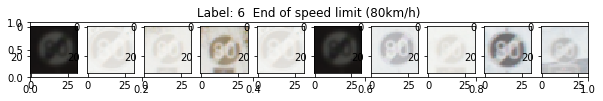

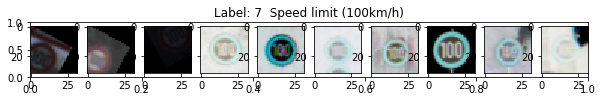

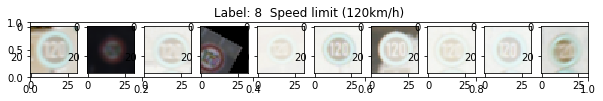

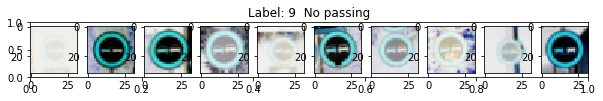

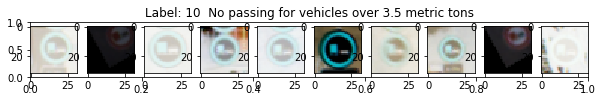

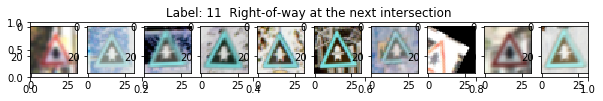

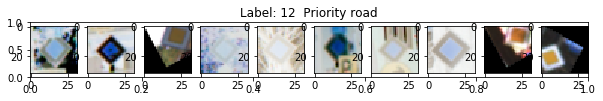

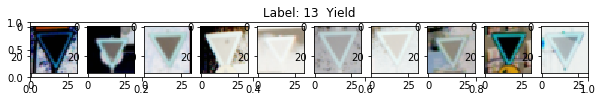

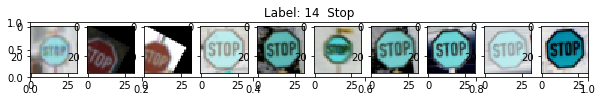

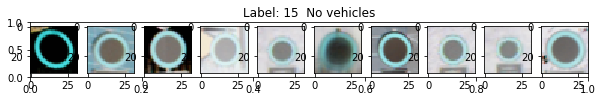

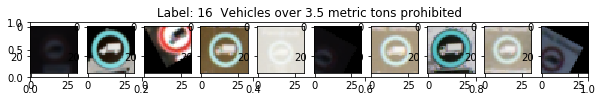

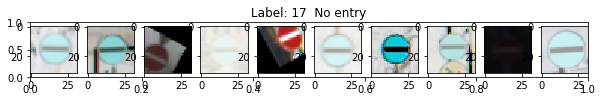

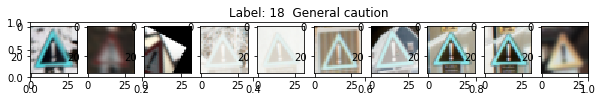

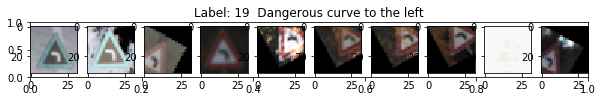

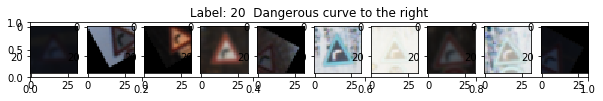

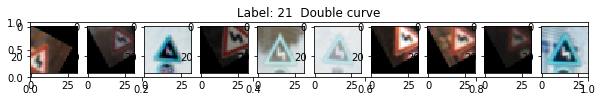

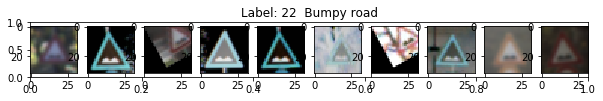

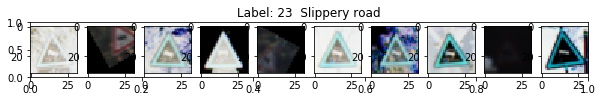

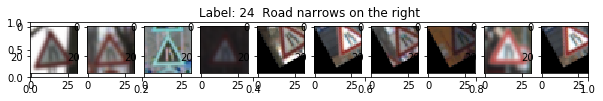

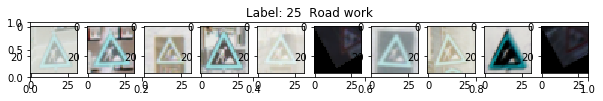

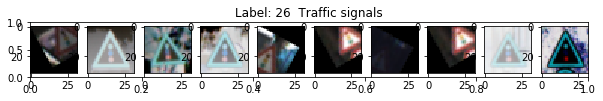

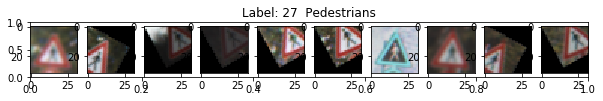

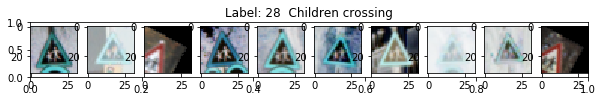

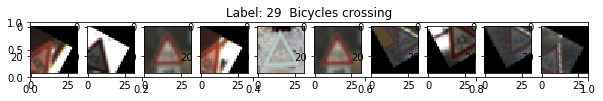

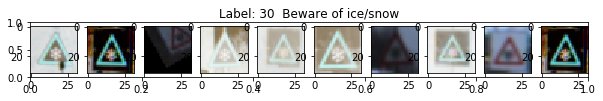

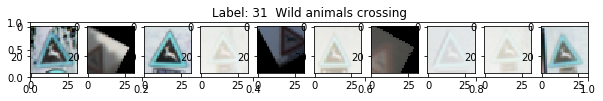

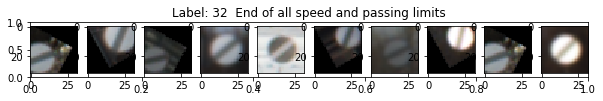

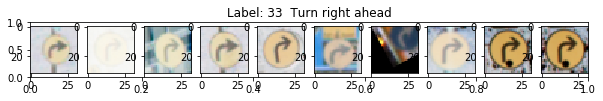

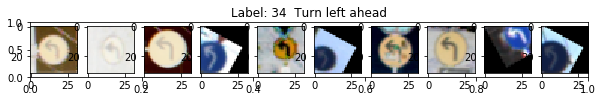

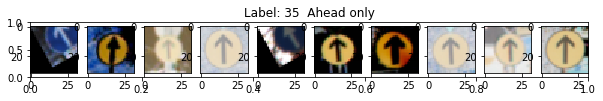

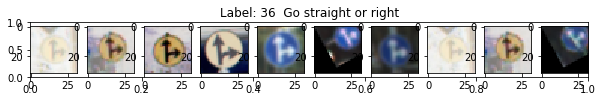

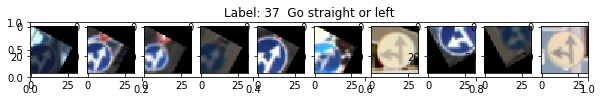

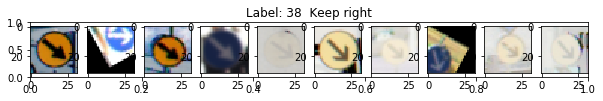

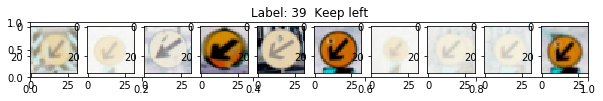

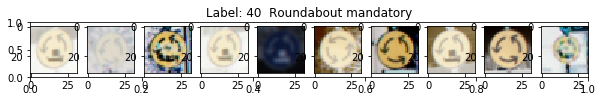

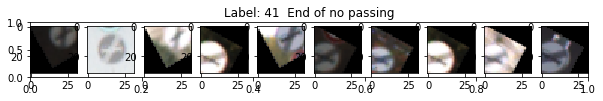

In [84]:
plt.rcParams['figure.figsize'] =(10,6) 

for label in range(0,42):
    fig = plt.figure(figsize=(10,1))
    #plt.axes(frameon=False)

    df_dag_filtered = df2_dag.query('ClassId==@label') #filtering the dataframe for specific label and storing it in df_filtered
    plt.title('Label: '+str(label)+'  '+str(df_dag.loc[label,'SignName']))
    for img in range(1,11):
        rand2 = randint(0, len(df_dag_filtered))
        fig.add_subplot(1,10,img)
        plt.imshow(train_features_dag[df_dag_filtered.index[rand2-1]])
        

# Data Preprocessing 

In [85]:


x_train =preprocessing(train_features_dag)
x_valid =preprocessing(valid_features)
x_test =preprocessing(test_features)


/Users/wajid/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [86]:
pickle_dump(x_train, 'x_train_new')
pickle_dump(x_valid, 'x_valid_new')
pickle_dump(x_test, 'x_test_new')

In [23]:
x_train = pickle_load('x_train_new')
x_valid = pickle_load('x_valid_new')
x_test =pickle_load('x_test_new')

### Visualization data after data Preprocessing

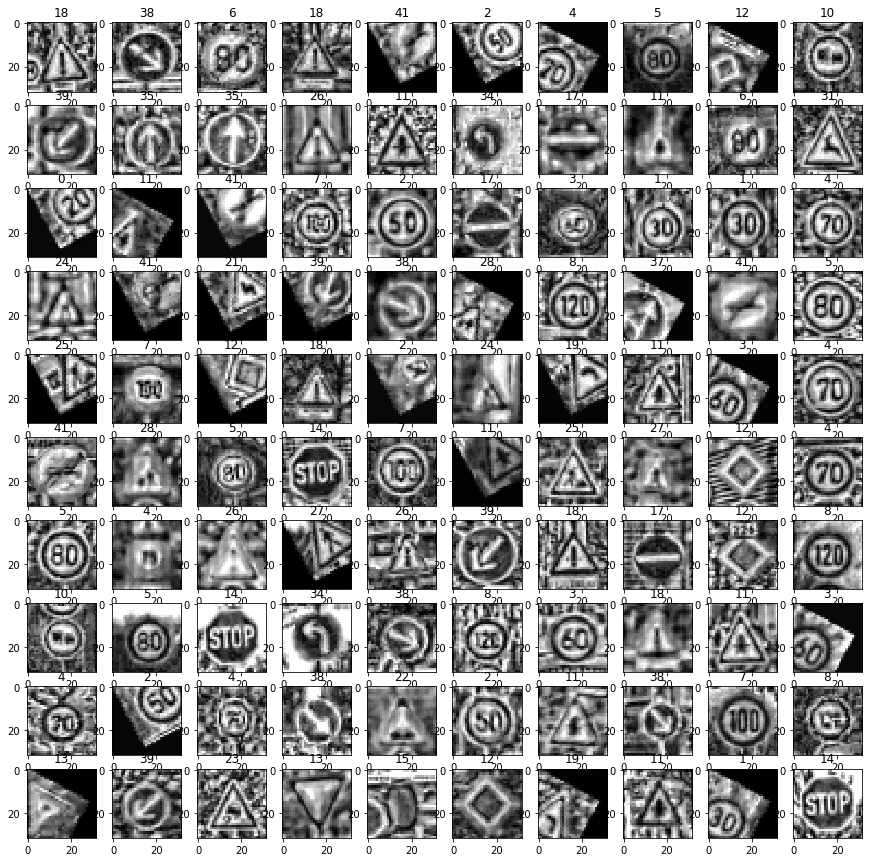

In [91]:
#Viewing 100 random images from the preprocessed data

view_100_images(x_train, train_labels_dag, index_start =0, index_end=len(x_train), random=True, cmap_name='gray')

In [24]:
#Modify  the shape to suit to input of the model
x_train= x_train.reshape(x_train.shape + (1,))
x_valid= x_valid.reshape(x_valid.shape + (1,))
x_test= x_test.reshape(x_test.shape + (1,))

#Verify the shape
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)


(52496, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


# Model Architechture

In [25]:
def LeNet(x,dropout_prob): 
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    keep_prob = dropout_prob
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6. 12
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 12), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)
    # SOLUTION: Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16. 24
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 24), mean = mu, stddev = sigma)) #(5,5,6,16)
    conv2_b = tf.Variable(tf.zeros(24)) #16
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # SOLUTION: Pooling. Input = 10x10x16.24 Output = 5x5x16. 24
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16.24 Output = 400. 600
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. 600 Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(600, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma)) #changed here
    fc3_b  = tf.Variable(tf.zeros(43)) #changed here
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

# Training 

In [26]:

EPOCHS = 20
BATCH_SIZE = 128



x = tf.placeholder(tf.float32, (None, 32, 32,1))

y = tf.placeholder(tf.int32, (None))

dropout_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)

#Set learning rate here:
rate = 0.001

# The model outputs logits, conv1 and conv2. 
# Conv1 and Conv2 are outputted to view the activation after the model is trainned.

logits, conv1, conv2 = LeNet(x, dropout_prob) 

#calculate cross_entropy and softmax
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

#caluculate the loss
loss_operation = tf.reduce_mean(cross_entropy)

#Do backprop using Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#predictions
pred = tf.argmax(logits,1)

#labels
label = tf.argmax(one_hot_y,1)

#Compare to predictions and labels to get correct predictions
correct_prediction = tf.equal(pred, label)

#Caculate the reduced mean of correct prediction for evaluation in accuracy
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


In [32]:

# Start the session for Training the model 

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    num_examples = len(x_train)
    
    print("Training...")
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(x_train, train_labels_dag)
        for offset in range(0, num_examples, BATCH_SIZE): # start from zero to batch_size until num_examples 
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end] 
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout_prob:0.6})
        
        validation_accuracy = evaluate(x_valid, valid_label) #changed here
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
       
    saver.save(sess, './lenet_final')
    sess.close()
    print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.786
EPOCH 2 ...
Validation Accuracy = 0.896
EPOCH 3 ...
Validation Accuracy = 0.907
EPOCH 4 ...
Validation Accuracy = 0.934
EPOCH 5 ...
Validation Accuracy = 0.942
EPOCH 6 ...
Validation Accuracy = 0.941
EPOCH 7 ...
Validation Accuracy = 0.945
EPOCH 8 ...
Validation Accuracy = 0.951
EPOCH 9 ...
Validation Accuracy = 0.956
EPOCH 10 ...
Validation Accuracy = 0.961
EPOCH 11 ...
Validation Accuracy = 0.964
EPOCH 12 ...
Validation Accuracy = 0.969
EPOCH 13 ...
Validation Accuracy = 0.964
EPOCH 14 ...
Validation Accuracy = 0.969
EPOCH 15 ...
Validation Accuracy = 0.961
EPOCH 16 ...
Validation Accuracy = 0.970
EPOCH 17 ...
Validation Accuracy = 0.970
EPOCH 18 ...
Validation Accuracy = 0.974
EPOCH 19 ...
Validation Accuracy = 0.972
EPOCH 20 ...
Validation Accuracy = 0.973
Model saved


# Performance Analysis

In [33]:
# get prediction label from the trained model for validation data
y_prediction, y_label = get_pred_label(x_valid,valid_label) 

#Get precision
precision = precision_score(y_label, y_prediction,  average=None)

#Get recall
recall = recall_score(y_label, y_prediction,  average=None)

41    0.482759
27    0.857143
31    0.927083
4     0.933333
32    0.935484
16    0.937500
19    0.937500
18    0.944444
5     0.948837
11    0.955414
Name: 0, dtype: float64

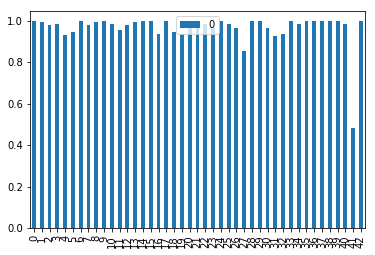

In [34]:
#Load the predicision in a dataframe for plotting purpose
df_pre = pd.DataFrame(precision)

#plot bar graph of precision to analyze
df_pre.plot(kind='bar')

#See the top 10 lowest precision labels
df_pre[0].nsmallest(10)

16    0.500000
0     0.566667
21    0.800000
20    0.816667
24    0.866667
26    0.900000
41    0.933333
3     0.946667
32    0.966667
40    0.966667
Name: 0, dtype: float64

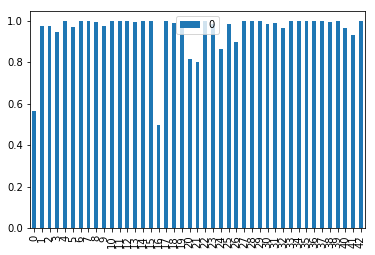

In [35]:
#Load the recall in a dataframe for plotting purpose
df_re = pd.DataFrame(recall)

#plot bar graph of recall to analyze
df_re.plot(kind='bar')

#See the top 10 lowest recall labels
df_re[0].nsmallest(10)

# Test results

In [36]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(x_test, test_label)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.956


(1, 14, 14, 12)
(1, 5, 5, 24)


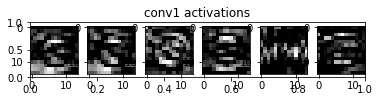

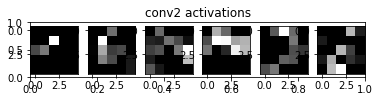

In [173]:
#Viewing feature maps of the test image

with tf.Session() as sess:
    print_activations(x_test)

# Web Images Results

In [175]:
#Loading the downloaded web images 
images = glob.glob('./web_images/img*.jpeg')

web_images =np.zeros((len(images),32,32,3))

#Resizing and reading the images into numpy array
for fname, i in zip(images, range(len(images))):
    wb_images= ski_tr.rescale(plt.imread(fname), 0.3, mode='reflect')
    web_images[i] = ski_tr.resize(wb_images, (32,32,3))

#Preprocessing
x_web = preprocessing(web_images)
x_web= x_web.reshape(x_web.shape + (1,))

#Setting up labels
web_label = np.array((8, 11, 34, 13, 33), dtype=np.uint8)
print(x_web.shape)

(5, 32, 32, 1)


/Users/wajid/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wajid/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wajid/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wajid/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode

In [176]:
#Predicting web images and printing the accuracy
with tf.Session() as sess:
    saver.restore(sess, './lenet_final')

    web_accuracy= evaluate(x_web, web_label)
    print(web_accuracy)

0.800000011921


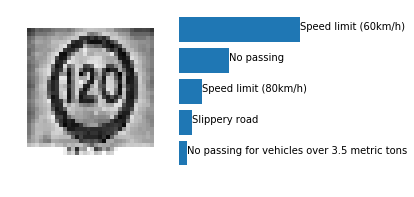

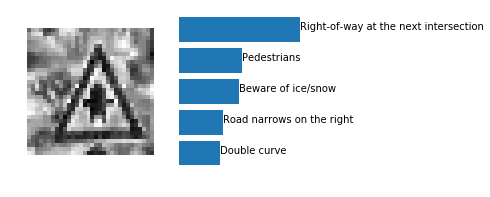

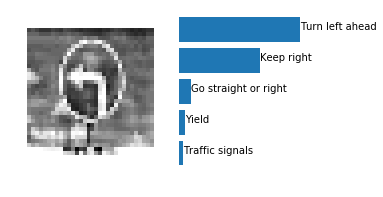

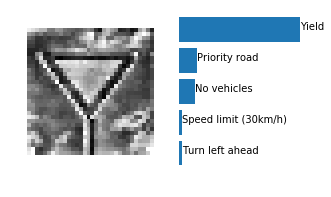

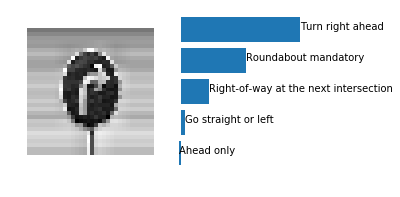

In [177]:
#Getting top5 softmax and plotting bar graph to view the predictions

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5_softmax = get_top5_softmax(x_web, web_label)
    plot_top5_softmax(x_web, top5_softmax)